In [35]:
import cv2
import os
import numpy as np
from keras import layers
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

In [14]:
# görüntülerin bulunduğu dizin
image_dir = r"C:\Software\bloodcells_dataset"

# Kenar algılamanın kaydedileceği dizin
edges_image_dir = r"C:\Software\edges_bloodcells_dataset"

# Eğer kenar algılama görüntü dizini yoksa oluştur
if not os.path.exists(edges_image_dir):
    os.makedirs(edges_image_dir)

# Alt dizinlerdeki görüntüleri işlemek için os.walk kullanımı
for subdir, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):  # Görüntü dosya uzantıları
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Sobel kenar algılama
                sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # X yönünde
                sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Y yönünde
                sobel_combined = cv2.magnitude(sobelx, sobely)
                sobel_combined = np.uint8(np.absolute(sobel_combined))

                # Dosya adını ve uzantısını ayırma
                filename, file_extension = os.path.splitext(file)

                # Kenar algılamanın kaydedileceği alt dizini oluşturma
                relative_path = os.path.relpath(subdir, image_dir)
                output_subdir = os.path.join(edges_image_dir, relative_path)
                if not os.path.exists(output_subdir):
                    os.makedirs(output_subdir)

                # Sobel kenar algılama sonucunu ayrı dosyaya kaydetme
                sobel_edge_file = os.path.join(output_subdir, f"sobel_{filename}.png")
                cv2.imwrite(sobel_edge_file, sobel_combined)


Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


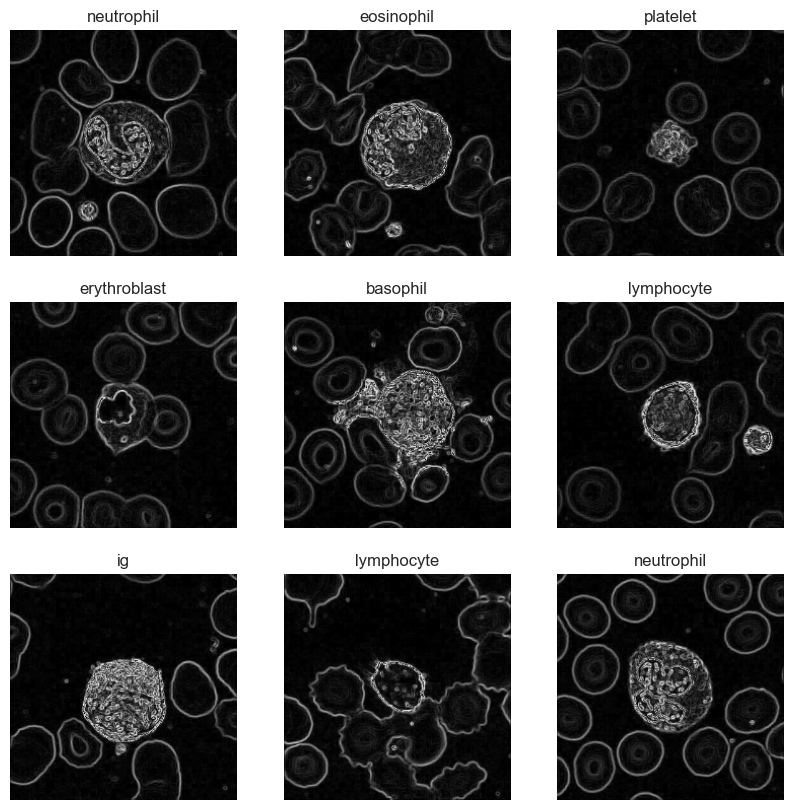

In [15]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn tema ayarı
sns.set_theme(style="ticks")

# Veri kümelerini hazırlama
edges_image_dir = r"C:\Software\edges_bloodcells_dataset"

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

edges_dataset, edges_test_dataset = keras.utils.image_dataset_from_directory(directory=edges_image_dir,
                                                                             image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                             batch_size=BATCH_SIZE,
                                                                             label_mode="int",
                                                                             validation_split=0.2,
                                                                             subset="both",
                                                                             shuffle=True,
                                                                             seed=42)

# Sınıf isimlerini getirme
edges_class_names = edges_dataset.class_names
print(edges_class_names)

# Veri kümesinden örnek görüntüler gösterme
plt.figure(figsize=(10, 10))
for images, labels in edges_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(edges_class_names[labels[i]])
        plt.axis("off")
plt.show()


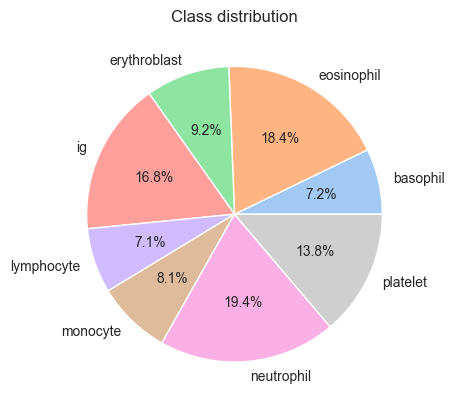

In [16]:
#Etiket dağılımını grafikte gösterme 
labels = np.concatenate([label for image, label in edges_dataset], axis=0)
unique, counts = np.unique(labels, return_counts=True)
plt.pie(x=counts, labels=edges_class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
        colors=sns.color_palette('pastel')[0:8])
plt.title("Class distribution")
plt.show()

In [17]:
#  Veri kümesini eğitim ve doğrulama setine ayırma 
num_elements = len(edges_dataset)
train_size = int(0.8 * num_elements)
val_dataset = edges_dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = edges_dataset.take(train_size).prefetch(tf.data.AUTOTUNE)

# uzunlukları kontrol etme 
len(train_dataset), len(val_dataset), len(edges_test_dataset)

(342, 86, 107)

In [19]:
# Formatı kontrol etme
# Görüntünün boyutlarını kontrol etme
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in edges_test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [20]:
# Piksel yoğunluklarını kontrol etme
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(252.20898, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [21]:
#
lab_book = {}

# early stopping callback oluşturma
early_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [24]:
# 
name = "Model"

# modeli oluşturma
tf.random.set_seed(42)
model = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ], name=name)

model.summary()

# modeli derleme
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# modeli egitme
history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# modelin dogruluk oranı
train_accuracy = model.evaluate(train_dataset)[1]
val_accuracy = model.evaluate(val_dataset)[1]
lab_book[name] = {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │         802,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,048 (3.06 MB)

 Trainable params: 803,048 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.5013 - loss: 1.5197 - val_accuracy: 0.7201 - val_loss: 0.8040
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.8810 - loss: 0.3757 - val_accuracy: 0.7275 - val_loss: 0.8265
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.9713 - loss: 0.1341 - val_accuracy: 0.6916 - val_loss: 1.0850
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.9948 - loss: 0.0476 - val_accuracy: 0.7168 - val_loss: 1.0199
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9996 - loss: 0.0163 - val_accuracy: 0.7037 - val_loss: 1.1860
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.9962 - loss: 0.0239 - val_accuracy: 0.6835 - val_loss: 1.2781
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.9990 - loss: 0.0112 - val_accuracy: 0.7136 - val_loss: 1.1689
342/342 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9679 - loss: 0.1446

In [25]:
# 
#data_augmentation = keras.Sequential([
    #keras.layers.RandomFlip("horizontal_and_vertical"),
    #keras.layers.RandomRotation(0.4)
    #])

In [26]:
# modelin test setinin doğruluğunun tahmin edilmesi
test_scores = {}
test_accuracy = model.evaluate(edges_test_dataset)[1]
test_scores["Model"] = test_accuracy

107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7132 - loss: 0.8708


In [27]:
# 
y_pred = []
y_pred_proba = []
y_true = []


# veri kümesi üzerinde yineleme işlemi
for image_batch, label_batch in edges_test_dataset:
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))


correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

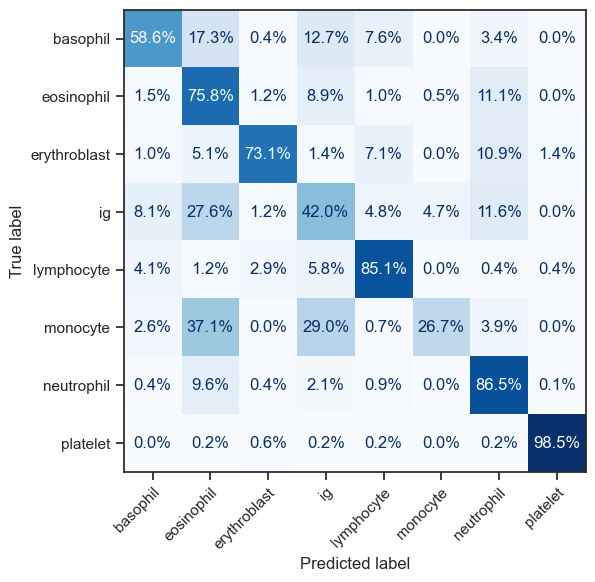

In [30]:
# modelin confusion matrisini gösterme
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=edges_class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=edges_class_names, rotation=45,
                     ha='right',
                     rotation_mode='anchor')
plt.show()

In [37]:
model.save(r"C:\Users\Gül\PycharmProjects\notebooks\71_edges_sobel_model.keras")